# Markov Mixing Investigation in mHC

This notebook runs experiments to investigate whether doubly stochastic H_res matrices in mHC exhibit Markov chain mixing.

## Setup

In [1]:
# Clone the repository
!git clone https://github.com/tokenbender/mHC-manifold-constrained-hyper-connections

Cloning into 'mHC-manifold-constrained-hyper-connections'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 318 (delta 146), reused 150 (delta 104), pack-reused 115 (from 1)
Receiving objects: 100% (318/318), 81.90 KiB | 13.65 MiB/s, done.
Resolving deltas: 100% (189/189), done.


In [43]:
!cd /content/mHC-manifold-constrained-hyper-connections && git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 691 bytes | 345.00 KiB/s, done.
From https://github.com/pherber3/mHC-manifold-constrained-hyper-connections
   6707ee0..579ce92  main       -> origin/main
Updating 6707ee0..579ce92
Fast-forward
 hyper_connections/hyper_connections.py     | 8 ++++----
 hyper_connections/hyper_connections_mhc.py | 8 ++++----
 2 files changed, 8 insertions(+), 8 deletions(-)


In [2]:
# Install dependencies
%cd /content/mHC-manifold-constrained-hyper-connections
!pip install -e . --quiet
# !pip install -e ../.. --quiet
!pip install wandb --quiet

/content/mHC-manifold-constrained-hyper-connections
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 140.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 MB 48.8 MB/s eta 0:00:00
  Building editable for mhc-hyper-connections (pyproject.toml) ... done


In [46]:
# import importlib
# import hyper_connections
# importlib.reload(hyper_connections.hyper_connections)

<module 'hyper_connections.hyper_connections' from '/content/mHC-manifold-constrained-hyper-connections/hyper_connections/hyper_connections.py'>

In [4]:
!python -c "from hyper_connections.hyper_connections import HyperConnections; hc = HyperConnections(4, dim=64, mhc=True); print('H_res_logits:', hc.H_res_logits)"

H_res_logits: Parameter containing:
tensor([[ 0., -8., -8., -8.],
        [-8.,  0., -8., -8.],
        [-8., -8.,  0., -8.],
        [-8., -8., -8.,  0.]], requires_grad=True)


In [3]:
# Verify GPU is available
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.2 GB


## Run Unit Tests

In [6]:
# Run all Markov mixing tests
!pytest tests/test_markov_mixing.py -v

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/mHC-manifold-constrained-hyper-connections
configfile: pyproject.toml
plugins: langsmith-0.4.59, anyio-4.12.0, typeguard-4.4.4
collected 0 items                                                              

============================ no tests ran in 0.00s =============================
ERROR: file or directory not found: tests/test_markov_mixing.py



In [7]:
# Run existing HC tests to make sure nothing broke
!pytest tests/test_hyper_connections.py -v

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/mHC-manifold-constrained-hyper-connections
configfile: pyproject.toml
plugins: langsmith-0.4.59, anyio-4.12.0, typeguard-4.4.4
collected 19 items                                                             

tests/test_hyper_connections.py::test_readme[False-1] PASSED             [  5%]
tests/test_hyper_connections.py::test_readme[False-4] PASSED             [ 10%]
tests/test_hyper_connections.py::test_readme[True-1] PASSED              [ 15%]
tests/test_hyper_connections.py::test_readme[True-4] PASSED              [ 21%]
tests/test_hyper_connections.py::test_manual PASSED                      [ 26%]
tests/test_hyper_connections.py::test_multi_input_hyper_connections[False] PASSED [ 31%]
tests/test_hyper_connections.py::test_multi_input_hyper_connections[True] PASSED [ 36%]
tests/test_

## Quick Sanity Check (No Training)

In [6]:
# Test spectral analysis functions directly
import torch
from hyper_connections.hyper_connections import sinkhorn_log
from analysis.spectral import analyze_h_res, spectral_gap
from analysis.markov_metrics import cumulative_product_metrics

# Create some random H_res matrices
num_layers = 12
num_streams = 4

h_res_list = []
for i in range(num_layers):
    logits = torch.randn(num_streams, num_streams)
    H = sinkhorn_log(logits, num_iters=10, tau=0.05)
    h_res_list.append(H)

    props = analyze_h_res(H)
    print(f"Layer {i}: |λ₂|={props['lambda_2_abs']:.4f}, gap={props['spectral_gap']:.4f}")

print("\n--- Cumulative Product Analysis ---")
metrics = cumulative_product_metrics(h_res_list)
for i in range(len(metrics['dist_to_uniform'])):
    print(f"Depth {i}: dist_to_uniform={metrics['dist_to_uniform'][i]:.4f}, gap={metrics['spectral_gap'][i]:.4f}")

Layer 0: |λ₂|=0.7039, gap=0.2961
Layer 1: |λ₂|=0.9251, gap=0.0749
Layer 2: |λ₂|=0.9619, gap=0.0381
Layer 3: |λ₂|=0.9995, gap=0.0005
Layer 4: |λ₂|=0.9967, gap=0.0033
Layer 5: |λ₂|=0.8765, gap=0.1235
Layer 6: |λ₂|=0.9484, gap=0.0516
Layer 7: |λ₂|=0.9997, gap=0.0003
Layer 8: |λ₂|=0.3848, gap=0.6152
Layer 9: |λ₂|=0.9867, gap=0.0133
Layer 10: |λ₂|=0.6885, gap=0.3115
Layer 11: |λ₂|=0.8894, gap=0.1106

--- Cumulative Product Analysis ---
Depth 0: dist_to_uniform=1.4381, gap=0.2961
Depth 1: dist_to_uniform=1.2807, gap=0.1908
Depth 2: dist_to_uniform=1.2085, gap=0.2471
Depth 3: dist_to_uniform=1.0939, gap=0.2537
Depth 4: dist_to_uniform=1.0095, gap=0.5378
Depth 5: dist_to_uniform=0.6725, gap=0.7614
Depth 6: dist_to_uniform=0.5197, gap=0.8630
Depth 7: dist_to_uniform=0.5257, gap=0.6510
Depth 8: dist_to_uniform=0.5521, gap=0.8400
Depth 9: dist_to_uniform=0.5623, gap=0.8638
Depth 10: dist_to_uniform=0.5983, gap=0.8925
Depth 11: dist_to_uniform=0.2824, gap=0.8979


## Download FineWeb10B Data

In [6]:
%cd examples/nanogpt
!python data/fineweb10B/download.py

/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt
  - 1 validation shard
  - 9 training shards

  downloading fineweb_val_000000.bin...
fineweb_val_000000.bin: 100% 200M/200M [00:02<00:00, 97.4MB/s]
  downloading fineweb_train_000001.bin...
fineweb_train_000001.bin: 100% 200M/200M [00:01<00:00, 148MB/s]
  downloading fineweb_train_000002.bin...
fineweb_train_000002.bin: 100% 200M/200M [00:01<00:00, 110MB/s]
  downloading fineweb_train_000003.bin...
fineweb_train_000003.bin: 100% 200M/200M [00:01<00:00, 152MB/s]
  downloading fineweb_train_000004.bin...
fineweb_train_000004.bin: 100% 200M/200M [00:01<00:00, 174MB/s]
  downloading fineweb_train_000005.bin...
fineweb_train_000005.bin: 100% 200M/200M [00:02<00:00, 84.0MB/s]
  downloading fineweb_train_000006.bin...
fineweb_train_000006.bin: 100% 200M/200M [00:01<00:00, 140MB/s]
  downloading fineweb_train_000007.bin...
fineweb_train_000007.bin: 100% 200M/200M [00:01<00:00, 165MB/s]
  downloading fineweb_train_000008.bin.

## Phase 1: Baseline Characterization

Train a 6-layer mHC model to establish baseline spectral properties.

In [4]:
# Optional: Login to W&B
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:


KeyboardInterrupt: 

In [7]:
# Train 6-layer mHC baseline (quick test - 500 iters)
!python train.py config/train_fineweb10B_mhc.py \
    max_iters=500 \
    eval_interval=100 \
    spectral_log_interval=100 \
    out_dir="out-mhc-baseline-test"

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Found 9 train shards, 1 val shards
Train tokens: 900,000,000, Val tokens: 100,000,000
Training on cuda, dtype=bfloat16, DDP=False
  tokens per iteration: 131,072
  model params: 20,782,968

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 3
wandb: You chose "Don't visualize my results"
w

In [9]:
!pwd

/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt


In [12]:
# Analyze the checkpoint
!python /content/analyze_checkpoint.py --checkpoint out-mhc-baseline-test/ckpt.pt

Traceback (most recent call last):
  File "/content/analyze_checkpoint.py", line 22, in <module>
    from analysis.spectral import analyze_h_res
ModuleNotFoundError: No module named 'analysis'


In [16]:
from hyper_connections.hyper_connections import sinkhorn_log

# Load checkpoint
ckpt = torch.load("/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/out-mhc-baseline-test/ckpt.pt", map_location="cpu", weights_only=False)
state_dict = ckpt["model"]

# Find all H_res_logits keys
h_res_keys = sorted([k for k in state_dict if "H_res_logits" in k])

print(f"Found {len(h_res_keys)} H_res_logits tensors")

for key in h_res_keys:
    logits = state_dict[key]
    H = sinkhorn_log(logits, num_iters=10, tau=0.05)

    print(f"\n{key}:")
    print(f"  Logits:\n{logits}")
    print(f"  H_res (after Sinkhorn):\n{H}")
    print(f"  Off-diagonal sample: {logits[0, 1].item():.4f}")

Found 12 H_res_logits tensors

transformer.h.0.hc_attn.H_res_logits:
  Logits:
tensor([[ 0., -8., -8., -8.],
        [-8.,  0., -8., -8.],
        [-8., -8.,  0., -8.],
        [-8., -8., -8.,  0.]])
  H_res (after Sinkhorn):
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
  Off-diagonal sample: -8.0000

transformer.h.0.hc_mlp.H_res_logits:
  Logits:
tensor([[ 0., -8., -8., -8.],
        [-8.,  0., -8., -8.],
        [-8., -8.,  0., -8.],
        [-8., -8., -8.,  0.]])
  H_res (after Sinkhorn):
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
  Off-diagonal sample: -8.0000

transformer.h.1.hc_attn.H_res_logits:
  Logits:
tensor([[ 0., -8., -8., -8.],
        [-8.,  0., -8., -8.],
        [-8., -8.,  0., -8.],
        [-8., -8., -8.,  0.]])
  H_res (after Sinkhorn):
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
  Off-

## Full Training Run (6-layer baseline)

In [11]:
# Full 5000 iteration training
!python train.py config/train_fineweb10B_mhc.py

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Found 9 train shards, 1 val shards
Train tokens: 900,000,000, Val tokens: 100,000,000
Training on cuda, dtype=bfloat16, DDP=False
  tokens per iteration: 131,072
  model params: 20,782,968

wandb: Currently logged in as: pherber3 (glaucoma-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ Waiting for wandb.init()...
wandb: ⣻ setting up run

In [12]:
# Analyze the trained checkpoint
!python ../../scripts/analyze_checkpoint.py \
    --checkpoint out-fineweb10B-mhc/ckpt.pt \
    --output ../../analysis_results/baseline_6l

Analyzing checkpoint: out-fineweb10B-mhc/ckpt.pt
Projection method: sinkhorn

MARKOV MIXING ANALYSIS SUMMARY

Model Configuration:
  Layers (HC modules): 12
  Streams: 4

Per-Layer Statistics (averaged):
  |λ₂| (second eigenvalue): 1.0000
  Spectral gap (1 - |λ₂|): 0.0000

Cumulative Product Analysis:
  Initial dist to uniform: 1.7321
  Final dist to uniform: 1.7321
  Mixing ratio (final/initial): 1.0000
  Max spectral gap (cumulative): 0.0000

------------------------------------------------------------
INTERPRETATION:
  ✓ Per-layer |λ₂| > 0.9: Matrices are near-permutations
    Markov mixing is likely NOT a problem.
  ✓ Mixing ratio > 0.8: Staying far from uniform

Results saved to: ../../analysis_results/baseline_6l/mixing_analysis.json


## Residual-Only Ablation

Test whether H_pre/H_post injections compensate for mixing.

In [13]:
# Train residual-only variant
!python train.py config/train_fineweb10B_mhc_resonly.py

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Found 9 train shards, 1 val shards
Train tokens: 900,000,000, Val tokens: 100,000,000
Training on cuda, dtype=bfloat16, DDP=False
  tokens per iteration: 131,072
  model params: 20,782,968

wandb: Currently logged in as: pherber3 (glaucoma-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ Waiting for wandb.init()...
wandb: ⣻ setting up run

In [14]:
# Analyze residual-only checkpoint
!python ../../scripts/analyze_checkpoint.py \
    --checkpoint out-fineweb10B-mhc-resonly/ckpt.pt \
    --output ../../analysis_results/resonly_6l

Analyzing checkpoint: out-fineweb10B-mhc-resonly/ckpt.pt
Projection method: sinkhorn

MARKOV MIXING ANALYSIS SUMMARY

Model Configuration:
  Layers (HC modules): 12
  Streams: 4

Per-Layer Statistics (averaged):
  |λ₂| (second eigenvalue): 1.0000
  Spectral gap (1 - |λ₂|): 0.0000

Cumulative Product Analysis:
  Initial dist to uniform: 1.7321
  Final dist to uniform: 1.7321
  Mixing ratio (final/initial): 1.0000
  Max spectral gap (cumulative): 0.0000

------------------------------------------------------------
INTERPRETATION:
  ✓ Per-layer |λ₂| > 0.9: Matrices are near-permutations
    Markov mixing is likely NOT a problem.
  ✓ Mixing ratio > 0.8: Staying far from uniform

Results saved to: ../../analysis_results/resonly_6l/mixing_analysis.json


## 48-Layer Deep Model

In [15]:
# Train 48-layer mHC
!python train.py config/train_fineweb10B_mhc_48l.py

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Found 9 train shards, 1 val shards
Train tokens: 900,000,000, Val tokens: 100,000,000
Training on cuda, dtype=bfloat16, DDP=False
  tokens per iteration: 32,768
  model params: 20,779,350

wandb: Currently logged in as: pherber3 (glaucoma-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ Waiting for wandb.init()...
wandb: ⣻ setting up run 

In [16]:
# Analyze 48-layer checkpoint
!python ../../scripts/analyze_checkpoint.py \
    --checkpoint out-fineweb10B-mhc-48l/ckpt.pt \
    --output ../../analysis_results/mhc_48l

Analyzing checkpoint: out-fineweb10B-mhc-48l/ckpt.pt
Projection method: sinkhorn

MARKOV MIXING ANALYSIS SUMMARY

Model Configuration:
  Layers (HC modules): 96
  Streams: 4

Per-Layer Statistics (averaged):
  |λ₂| (second eigenvalue): 1.0000
  Spectral gap (1 - |λ₂|): 0.0000

Cumulative Product Analysis:
  Initial dist to uniform: 1.7321
  Final dist to uniform: 1.7321
  Mixing ratio (final/initial): 1.0000
  Max spectral gap (cumulative): 0.0000

------------------------------------------------------------
INTERPRETATION:
  ✓ Per-layer |λ₂| > 0.9: Matrices are near-permutations
    Markov mixing is likely NOT a problem.
  ✓ Mixing ratio > 0.8: Staying far from uniform

Results saved to: ../../analysis_results/mhc_48l/mixing_analysis.json


## Compare Sinkhorn vs Orthostochastic

In [17]:
# Train with orthostochastic projection
!python train.py config/train_fineweb10B_mhc.py \
    mhc_h_res_proj="orthostochastic" \
    out_dir="out-mhc-orthostochastic" \
    wandb_run_name="mhc-orthostochastic"

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Found 9 train shards, 1 val shards
Train tokens: 900,000,000, Val tokens: 100,000,000
Traceback (most recent call last):
  File "/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/train.py", line 304, in <module>
    model = GPT(model_config)
            ^^^^^^^^^^^^^^^^^
  File "/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/model.

In [18]:
# Analyze orthostochastic checkpoint
!python ../../scripts/analyze_checkpoint.py \
    --checkpoint out-mhc-orthostochastic/ckpt.pt \
    --projection orthostochastic \
    --output ../../analysis_results/orthostochastic_6l

Analyzing checkpoint: out-mhc-orthostochastic/ckpt.pt
Projection method: orthostochastic
Traceback (most recent call last):
  File "/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/../../scripts/analyze_checkpoint.py", line 245, in <module>
    sys.exit(main())
             ^^^^^^
  File "/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/../../scripts/analyze_checkpoint.py", line 207, in main
    results = run_analysis(
              ^^^^^^^^^^^^^
  File "/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/../../scripts/analyze_checkpoint.py", line 73, in run_analysis
    ckpt = load_checkpoint(checkpoint_path)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/mHC-manifold-constrained-hyper-connections/examples/nanogpt/../../scripts/analyze_checkpoint.py", line 28, in load_checkpoint
    return torch.load(path, map_location="cpu", weights_only=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  

## Custom Analysis

Run analysis directly in Python for more control.

In [19]:
import sys
sys.path.insert(0, '../..')

import torch
import matplotlib.pyplot as plt
from hyper_connections.hyper_connections import sinkhorn_log
from analysis.spectral import analyze_h_res
from analysis.markov_metrics import cumulative_product_metrics

def load_and_analyze(checkpoint_path, projection='sinkhorn'):
    """Load checkpoint and run full analysis."""
    ckpt = torch.load(checkpoint_path, map_location='cpu')
    state_dict = ckpt['model']

    # Extract H_res matrices
    h_res_keys = sorted([k for k in state_dict if 'H_res_logits' in k])
    h_res_list = []
    per_layer = {}

    for i, key in enumerate(h_res_keys):
        logits = state_dict[key]
        H = sinkhorn_log(logits, 10, 0.05)
        h_res_list.append(H)
        per_layer[i] = analyze_h_res(H)

    cumulative = cumulative_product_metrics(h_res_list)

    return per_layer, cumulative, h_res_list

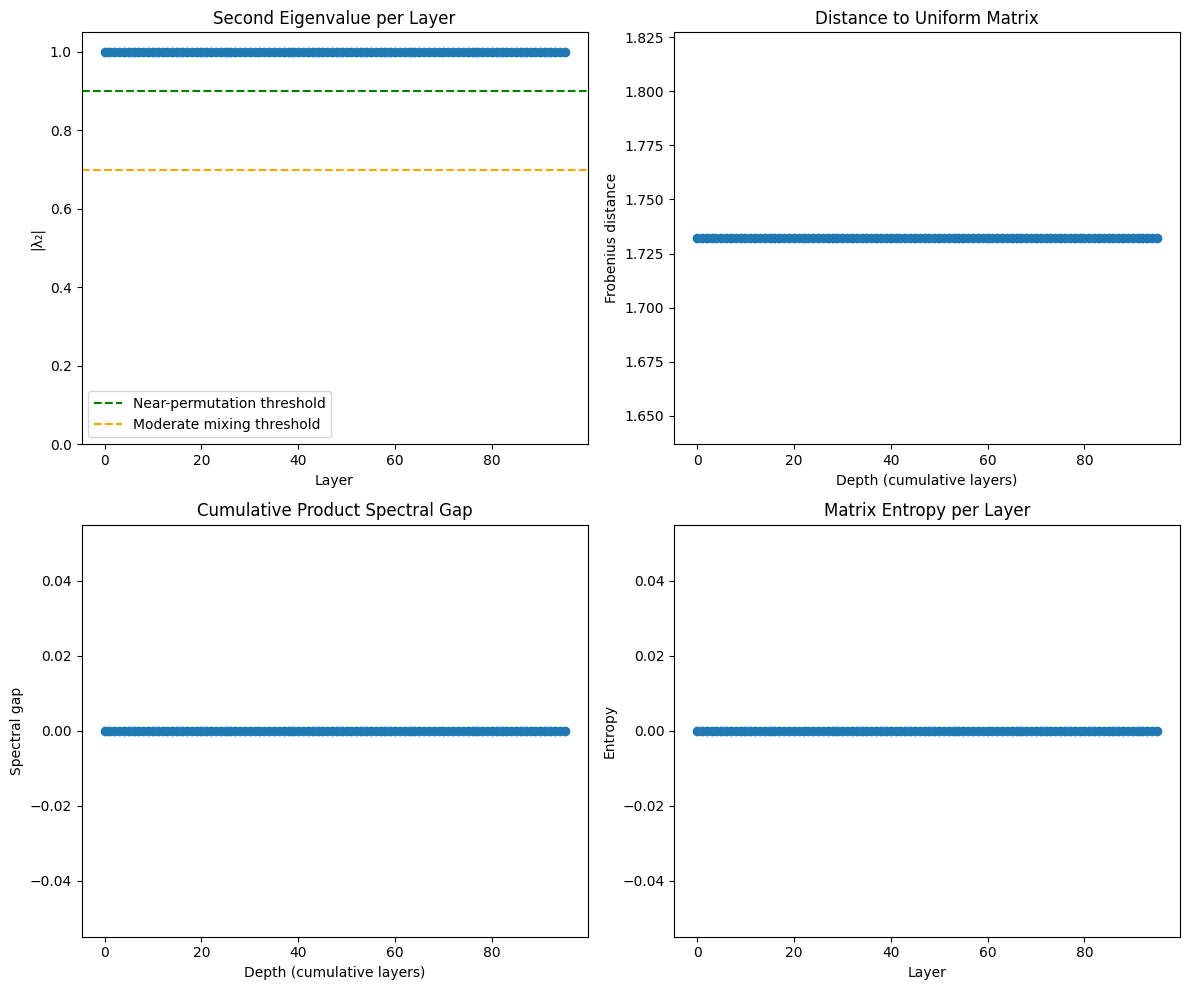

In [24]:
# Visualize results
def plot_mixing_analysis(per_layer, cumulative):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Per-layer |λ₂|
    ax = axes[0, 0]
    lambda2s = [per_layer[i]['lambda_2_abs'] for i in sorted(per_layer.keys())]
    ax.plot(lambda2s, 'o-')
    ax.axhline(y=0.9, color='g', linestyle='--', label='Near-permutation threshold')
    ax.axhline(y=0.7, color='orange', linestyle='--', label='Moderate mixing threshold')
    ax.set_xlabel('Layer')
    ax.set_ylabel('|λ₂|')
    ax.set_title('Second Eigenvalue per Layer')
    ax.legend()
    ax.set_ylim(0, 1.05)

    # Cumulative distance to uniform
    ax = axes[0, 1]
    ax.plot(cumulative['dist_to_uniform'], 'o-')
    ax.set_xlabel('Depth (cumulative layers)')
    ax.set_ylabel('Frobenius distance')
    ax.set_title('Distance to Uniform Matrix')

    # Cumulative spectral gap
    ax = axes[1, 0]
    ax.plot(cumulative['spectral_gap'], 'o-')
    ax.set_xlabel('Depth (cumulative layers)')
    ax.set_ylabel('Spectral gap')
    ax.set_title('Cumulative Product Spectral Gap')

    # Per-layer entropy
    ax = axes[1, 1]
    entropies = [per_layer[i]['entropy'] for i in sorted(per_layer.keys())]
    ax.plot(entropies, 'o-')
    ax.set_xlabel('Layer')
    ax.set_ylabel('Entropy')
    ax.set_title('Matrix Entropy per Layer')

    plt.tight_layout()
    plt.show()

# Example usage (uncomment after training):
per_layer, cumulative, h_res_list = load_and_analyze('out-fineweb10B-mhc-48l/ckpt.pt')
plot_mixing_analysis(per_layer, cumulative)

## Visualize H_res Matrices

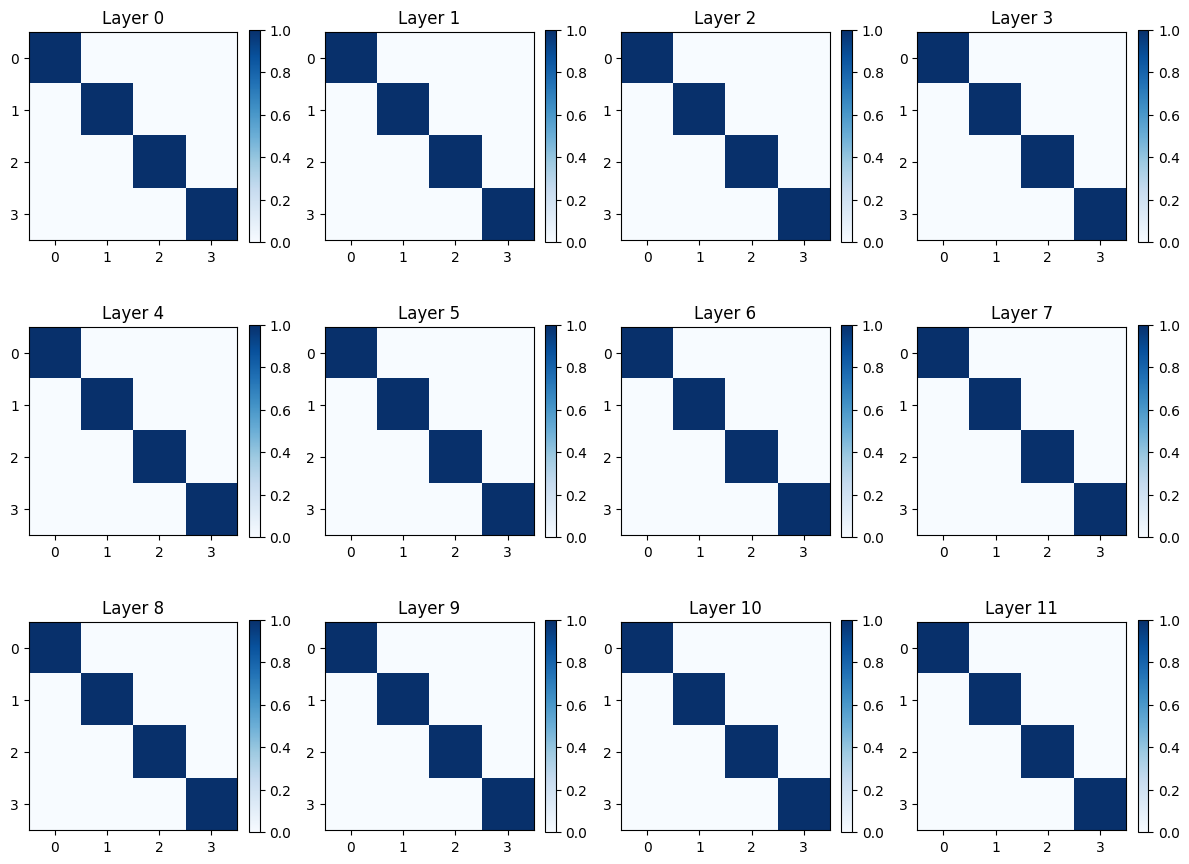

In [25]:
def plot_h_res_heatmaps(h_res_list, max_show=12):
    """Visualize H_res matrices as heatmaps."""
    n_show = min(len(h_res_list), max_show)
    cols = 4
    rows = (n_show + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten() if n_show > 1 else [axes]

    for i in range(n_show):
        ax = axes[i]
        H = h_res_list[i].numpy()
        im = ax.imshow(H, cmap='Blues', vmin=0, vmax=1)
        ax.set_title(f'Layer {i}')
        ax.set_xticks(range(H.shape[0]))
        ax.set_yticks(range(H.shape[0]))
        plt.colorbar(im, ax=ax, fraction=0.046)

    # Hide unused subplots
    for i in range(n_show, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage (uncomment after training):
plot_h_res_heatmaps(h_res_list)

## Compare Multiple Checkpoints

In [22]:
def compare_checkpoints(checkpoint_paths, labels):
    """Compare mixing behavior across multiple checkpoints."""
    results = {}
    for path, label in zip(checkpoint_paths, labels):
        try:
            per_layer, cumulative, _ = load_and_analyze(path)
            results[label] = {
                'per_layer': per_layer,
                'cumulative': cumulative
            }
        except FileNotFoundError:
            print(f"Checkpoint not found: {path}")

    if not results:
        print("No checkpoints found!")
        return

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Compare cumulative distance to uniform
    ax = axes[0]
    for label, data in results.items():
        ax.plot(data['cumulative']['dist_to_uniform'], 'o-', label=label)
    ax.set_xlabel('Depth')
    ax.set_ylabel('Distance to Uniform')
    ax.set_title('Cumulative Mixing Comparison')
    ax.legend()

    # Compare avg |λ₂| per layer
    ax = axes[1]
    for label, data in results.items():
        lambda2s = [data['per_layer'][i]['lambda_2_abs']
                    for i in sorted(data['per_layer'].keys())]
        ax.plot(lambda2s, 'o-', label=label)
    ax.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Layer')
    ax.set_ylabel('|λ₂|')
    ax.set_title('Per-Layer Second Eigenvalue')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage (uncomment after training multiple models):
# compare_checkpoints(
#     ['out-fineweb10B-mhc/ckpt.pt', 'out-fineweb10B-mhc-48l/ckpt.pt'],
#     ['6-layer', '48-layer']
# )

In [23]:
import torch
ckpt = torch.load('out-fineweb10B-mhc-48l/ckpt.pt', map_location='cpu', weights_only=False)
state_dict = ckpt['model']

h_res_keys = sorted([k for k in state_dict if 'H_res_logits' in k])
print(f'Found {len(h_res_keys)} H_res_logits')

# Check first and last few
for i, key in enumerate(h_res_keys[:3] + h_res_keys[-3:]):
    logits = state_dict[key]
    print(f'\n{key}:')
    print(f'  diagonal mean: {logits.diag().mean():.4f}')
    print(f'  off-diag mean: {logits[~torch.eye(4, dtype=bool)].mean():.4f}')
    print(f'  off-diag max:  {logits[~torch.eye(4, dtype=bool)].max():.4f}')
    print(f'  off-diag min:  {logits[~torch.eye(4, dtype=bool)].min():.4f}')

Found 96 H_res_logits

transformer.h.0.hc_attn.H_res_logits:
  diagonal mean: 0.0000
  off-diag mean: -8.0000
  off-diag max:  -8.0000
  off-diag min:  -8.0000

transformer.h.0.hc_mlp.H_res_logits:
  diagonal mean: 0.0000
  off-diag mean: -8.0000
  off-diag max:  -8.0000
  off-diag min:  -8.0000

transformer.h.1.hc_attn.H_res_logits:
  diagonal mean: 0.0000
  off-diag mean: -8.0000
  off-diag max:  -8.0000
  off-diag min:  -8.0000

transformer.h.8.hc_mlp.H_res_logits:
  diagonal mean: 0.0000
  off-diag mean: -8.0000
  off-diag max:  -8.0000
  off-diag min:  -8.0000

transformer.h.9.hc_attn.H_res_logits:
  diagonal mean: 0.0000
  off-diag mean: -8.0000
  off-diag max:  -8.0000
  off-diag min:  -8.0000

transformer.h.9.hc_mlp.H_res_logits:
  diagonal mean: 0.0000
  off-diag mean: -8.0000
  off-diag max:  -8.0000
  off-diag min:  -8.0000
